## Chapter 1 RNN으로 비트 코인 가격 예측하기

In [2]:
!pip install -q torchinfo

In [3]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn, optim
from torchinfo import summary

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

True cuda


In [5]:
seed = 1202
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

### 1.3 비트코인 가격 데이터

In [6]:
!wget https://www.cryptodatadownload.com/cdd/Bithumb_BTCKRW_d.csv

--2023-12-02 14:14:42--  https://www.cryptodatadownload.com/cdd/Bithumb_BTCKRW_d.csv
Resolving www.cryptodatadownload.com (www.cryptodatadownload.com)... 35.173.69.207
Connecting to www.cryptodatadownload.com (www.cryptodatadownload.com)|35.173.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111438 (109K) [text/csv]
Saving to: ‘Bithumb_BTCKRW_d.csv’

Bithumb_BTCKRW_d.cs 100%[===================>] 108.83K  --.-KB/s    in 0.06s   

2023-12-02 14:14:42 (1.87 MB/s) - ‘Bithumb_BTCKRW_d.csv’ saved [111438/111438]



In [7]:
df = pd.read_csv("Bithumb_BTCKRW_d.csv", skiprows=1)
df['Date'] = df['Date'].apply(pd.Timestamp)
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
print(df.shape)
print(df)

(1267, 8)
            Unix Timestamp  Symbol      Open      High       Low     Close  \
Date                                                                         
2017-05-22    1.495411e+09  BTCKRW   3027000   3195000   2966000   3104000   
2017-05-23    1.495498e+09  BTCKRW   3104000   3281000   3081000   3206000   
2017-05-24    1.495584e+09  BTCKRW   3206000   4314000   3206000   4175000   
2017-05-25    1.495670e+09  BTCKRW   4175000   4840000   3102000   4199000   
2017-05-26    1.495757e+09  BTCKRW   4199000   4200000   2900000   3227000   
...                    ...     ...       ...       ...       ...       ...   
2020-11-16    1.605485e+09  BTCKRW  17679000  18440000  17560000  18264000   
2020-11-17    1.605571e+09  BTCKRW  18264000  19411000  18179000  19350000   
2020-11-18    1.605658e+09  BTCKRW  19350000  20300000  19058000  19713000   
2020-11-19    1.605744e+09  BTCKRW  19713000  20026000  19379000  19799000   
2020-11-20    1.605830e+09  BTCKRW  19799000  20151000

In [8]:
df_close = df.loc[:, ["Close"]]
print(df_close.tail())

               Close
Date                
2020-11-16  18264000
2020-11-17  19350000
2020-11-18  19713000
2020-11-19  19799000
2020-11-20  20072000


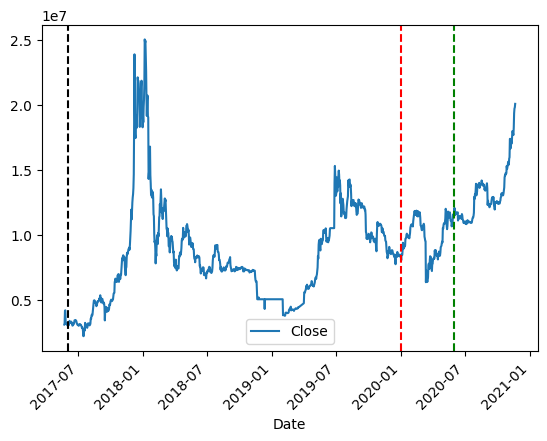

In [8]:
ax = df_close.plot(rot=45)
ax.axvline("2017-06-01", linestyle="--", c="black")
ax.axvline("2020-01-01", linestyle="--", c="red")
ax.axvline("2020-06-01", linestyle="--", c="green")

In [9]:
df_train = df_close[
  (df_close.index >= "2017-06-01")&(df_close.index < "2020-01-01")
]
print(df_train[:5])

              Close
Date               
2017-06-01  3142000
2017-06-02  3169000
2017-06-03  3110000
2017-06-04  3061000
2017-06-05  3188000


In [10]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df_train[:5])
data

array([[0.63779528],
       [0.8503937 ],
       [0.38582677],
       [0.        ],
       [1.        ]])

In [11]:
scaler.inverse_transform(data)

array([[3142000.],
       [3169000.],
       [3110000.],
       [3061000.],
       [3188000.]])

In [12]:
class BitcoinDataset(Dataset):
  def __init__(self, split="train", seq_len=4):
    self.split = split
    self.seq_len = seq_len

    self.date_range = {
      "train": ["2017-06-01", "2020-01-01"],
      "val": ["2020-01-01", "2020-06-01"],
      "test": ["2020-06-01", "2020-11-21"]
    }

    self.data = self._load_data(self.date_range[self.split])
    self.data, self.labels = self._transform(self.data, self.seq_len)

  def _load_data(self, date_range):
    df = pd.read_csv("Bithumb_BTCKRW_d.csv", skiprows=1)
    df['Date'] = df['Date'].apply(pd.Timestamp)
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)

    df_close = df.loc[:, ["Close"]]
    df = df_close[
      (df_close.index >= date_range[0])&(df_close.index < date_range[1])
    ]

    self.scaler = MinMaxScaler()
    data = self.scaler.fit_transform(df)
    return data

  def _transform(self, data, seq_len):
    x, y = [], []

    for i in range(len(data) - seq_len - 1):
      x_i = data[i:i+seq_len]
      y_i = data[i+1:i+seq_len+1]
      x.append(x_i)
      y.append(y_i)

    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)

    return x_tensor, y_tensor

  def __getitem__(self, i):
    return self.data[i], self.labels[i]

  def __len__(self):
    return len(self.data)

In [13]:
trainset = BitcoinDataset()
valset = BitcoinDataset(split="val")
testset = BitcoinDataset(split="test")

print(len(trainset), len(valset), len(testset))

927 147 168


In [18]:
def plot_sequence(x, y):
  plt.ylabel("Scaled Close")
  plt.xlabel("Time Bars")
  plt.plot(range(len(x)), x, color='r', label='Features')
  plt.plot(range(1, len(x)+1), y, color='b', linestyle='--', label='Target')
  plt.legend()

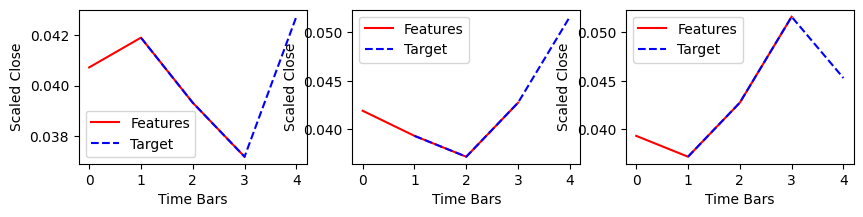

In [19]:
plt.figure(figsize=(10,2))
for i, (x, y) in enumerate(trainset):
  plt.subplot(1, 3, i+1)
  plot_sequence(x, y)

  if i == 2:
    break

### 1.4 LSTM 모델


In [17]:
model = nn.LSTM(4, 4)
summary(model, (1, 4))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 4]                    160
Total params: 160
Trainable params: 160
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [35]:
output, (hidden_state, cell_state) = model(torch.randn((1,4)).to(device))
print(output)
print(hidden_state)
print(cell_state)

tensor([[-0.1848, -0.1877,  0.1953, -0.0955]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([[-0.1848, -0.1877,  0.1953, -0.0955]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([[-0.6075, -0.4240,  0.2630, -0.1641]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


### 1.5 모델 학습

In [40]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  model.train()

  running_loss = 0

  with tqdm(dataloader) as pbar:
    for i, (features, targets) in enumerate(pbar):
      features = features.to(device)
      targets = targets.to(device)

      optimizer.zero_grad()

      outputs, _ = model(features)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      pbar.set_postfix(loss=loss.item())

  return running_loss/len(dataloader)

In [41]:
def validation(model, dataloader, criterion, epoch, device):
  model.eval()

  running_loss = 0

  with tqdm(dataloader) as pbar:
    with torch.no_grad():
      for i, (features, targets) in enumerate(pbar):
        features = features.to(device)
        targets = targets.to(device)

        outputs, _ = model(features)
        loss = criterion(outputs, targets)

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

  return running_loss/len(dataloader)

In [69]:
EPOCH = 60
BATCH_SIZE = 128
NUM_WORKERS = 2
LR = 0.1

trainset = BitcoinDataset()
valset = BitcoinDataset(split="val")
testset = BitcoinDataset(split="test")

train_loader = DataLoader(
  dataset=trainset,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
)
val_loader = DataLoader(
  dataset=valset,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
)
test_loader = DataLoader(
  dataset=testset,
  batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
)

# Model
model = nn.LSTM(4, 4)

# Optimizer, Loss, Scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

model = model.to(device)
criterion = criterion.to(device)

# Start Training
min_loss = 999
for epoch in range(EPOCH):
  print("LR:", scheduler.get_last_lr())

  tloss = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss = validation(model, val_loader, criterion, epoch, device)
  print(f'[{epoch}/{EPOCH}] valid loss: {vloss:.4f}\n')
  scheduler.step()

  if vloss < min_loss:
    print(f"Update Best Model: {vloss}")
    torch.save(model.state_dict(), "best.pth")
    min_loss = vloss

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 14.69it/s, loss=0.332]


[0/60] valid loss: 0.2432

Update Best Model: 0.24321478605270386
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 14.39it/s, loss=0.125]


[1/60] valid loss: 0.0901

Update Best Model: 0.09009485691785812
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 12.84it/s, loss=0.0535]


[2/60] valid loss: 0.0382

Update Best Model: 0.03822361957281828
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 14.04it/s, loss=0.0347]


[3/60] valid loss: 0.0252

Update Best Model: 0.025163723155856133
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 13.50it/s, loss=0.0108]


[4/60] valid loss: 0.0082

Update Best Model: 0.008235243847593665
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 14.32it/s, loss=0.0106]


[5/60] valid loss: 0.0079

Update Best Model: 0.007883735001087189
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 14.04it/s, loss=0.00988]


[6/60] valid loss: 0.0073

Update Best Model: 0.007310695946216583
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 14.31it/s, loss=0.00913]


[7/60] valid loss: 0.0069

Update Best Model: 0.00685717654414475
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 14.36it/s, loss=0.00883]


[8/60] valid loss: 0.0066

Update Best Model: 0.006595255807042122
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 12.71it/s, loss=0.00908]


[9/60] valid loss: 0.0068

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00,  8.71it/s, loss=0.00849]


[10/60] valid loss: 0.0064

Update Best Model: 0.0064131265971809626
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00,  8.36it/s, loss=0.00812]


[11/60] valid loss: 0.0062

Update Best Model: 0.006174624431878328
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00,  8.12it/s, loss=0.00773]


[12/60] valid loss: 0.0059

Update Best Model: 0.0059284132439643145
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00,  8.75it/s, loss=0.00759]


[13/60] valid loss: 0.0058

Update Best Model: 0.0058379643596708775
LR: [0.1]


100%|██████████| 2/2 [00:00<00:00,  9.16it/s, loss=0.00762]


[14/60] valid loss: 0.0059

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00,  9.06it/s, loss=0.0076]


[15/60] valid loss: 0.0059

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00,  9.11it/s, loss=0.00771]


[16/60] valid loss: 0.0060

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 12.40it/s, loss=0.00789]


[17/60] valid loss: 0.0062

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 12.48it/s, loss=0.0081]


[18/60] valid loss: 0.0064

LR: [0.1]


100%|██████████| 2/2 [00:00<00:00, 13.36it/s, loss=0.00794]


[19/60] valid loss: 0.0062

LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 12.71it/s, loss=0.00773]


[20/60] valid loss: 0.0060

LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 14.19it/s, loss=0.0073]


[21/60] valid loss: 0.0058

Update Best Model: 0.005809413269162178
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.72it/s, loss=0.00731]


[22/60] valid loss: 0.0057

Update Best Model: 0.0057407834101468325
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.08it/s, loss=0.00715]


[23/60] valid loss: 0.0056

Update Best Model: 0.005623348988592625
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 14.10it/s, loss=0.00691]


[24/60] valid loss: 0.0055

Update Best Model: 0.005467668874189258
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.82it/s, loss=0.00689]


[25/60] valid loss: 0.0054

Update Best Model: 0.005446701776236296
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.66it/s, loss=0.00677]


[26/60] valid loss: 0.0054

Update Best Model: 0.005367598962038755
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.43it/s, loss=0.00671]


[27/60] valid loss: 0.0053

Update Best Model: 0.005321823293343186
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 14.26it/s, loss=0.00669]


[28/60] valid loss: 0.0053

Update Best Model: 0.005310664419084787
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 14.49it/s, loss=0.00664]


[29/60] valid loss: 0.0053

Update Best Model: 0.005272461683489382
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 12.81it/s, loss=0.00662]


[30/60] valid loss: 0.0053

Update Best Model: 0.005256996373645961
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 14.05it/s, loss=0.0066]


[31/60] valid loss: 0.0052

Update Best Model: 0.005242329090833664
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.95it/s, loss=0.00657]


[32/60] valid loss: 0.0052

Update Best Model: 0.005219249636866152
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.47it/s, loss=0.00654]


[33/60] valid loss: 0.0052

Update Best Model: 0.005203819600865245
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 14.31it/s, loss=0.00652]


[34/60] valid loss: 0.0052

Update Best Model: 0.005185014219023287
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.56it/s, loss=0.00649]


[35/60] valid loss: 0.0052

Update Best Model: 0.005166097078472376
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.87it/s, loss=0.00646]


[36/60] valid loss: 0.0051

Update Best Model: 0.005148336756974459
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.12it/s, loss=0.00644]


[37/60] valid loss: 0.0051

Update Best Model: 0.005129612633027136
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 13.94it/s, loss=0.00641]


[38/60] valid loss: 0.0051

Update Best Model: 0.005111668608151376
LR: [0.020000000000000004]


100%|██████████| 2/2 [00:00<00:00, 14.37it/s, loss=0.00638]


[39/60] valid loss: 0.0051

Update Best Model: 0.005093370447866619
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 12.96it/s, loss=0.00638]


[40/60] valid loss: 0.0051

Update Best Model: 0.005090093123726547
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 13.62it/s, loss=0.00637]


[41/60] valid loss: 0.0051

Update Best Model: 0.005082861171104014
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 14.57it/s, loss=0.00636]


[42/60] valid loss: 0.0051

Update Best Model: 0.00507632945664227
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 12.60it/s, loss=0.00635]


[43/60] valid loss: 0.0051

Update Best Model: 0.00507199764251709
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 14.28it/s, loss=0.00635]


[44/60] valid loss: 0.0051

Update Best Model: 0.005069027771241963
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00,  9.65it/s, loss=0.00634]


[45/60] valid loss: 0.0051

Update Best Model: 0.00506615883205086
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00,  8.70it/s, loss=0.00634]


[46/60] valid loss: 0.0051

Update Best Model: 0.005062799900770187
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00,  8.71it/s, loss=0.00633]


[47/60] valid loss: 0.0051

Update Best Model: 0.005059014656580985
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00,  8.97it/s, loss=0.00632]


[48/60] valid loss: 0.0051

Update Best Model: 0.0050550722517073154
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00,  8.72it/s, loss=0.00632]


[49/60] valid loss: 0.0051

Update Best Model: 0.0050511324079707265
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00,  8.39it/s, loss=0.00631]


[50/60] valid loss: 0.0050

Update Best Model: 0.005047219572588801
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00,  8.39it/s, loss=0.00631]


[51/60] valid loss: 0.0050

Update Best Model: 0.0050433059222996235
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 12.14it/s, loss=0.0063]


[52/60] valid loss: 0.0050

Update Best Model: 0.005039372947067022
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 12.13it/s, loss=0.0063]


[53/60] valid loss: 0.0050

Update Best Model: 0.0050354182021692395
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 14.05it/s, loss=0.00629]


[54/60] valid loss: 0.0050

Update Best Model: 0.0050314306281507015
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 14.00it/s, loss=0.00628]


[55/60] valid loss: 0.0050

Update Best Model: 0.005027404520660639
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 13.70it/s, loss=0.00628]


[56/60] valid loss: 0.0050

Update Best Model: 0.005023336387239397
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 14.23it/s, loss=0.00627]


[57/60] valid loss: 0.0050

Update Best Model: 0.0050192337948828936
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 13.07it/s, loss=0.00627]


[58/60] valid loss: 0.0050

Update Best Model: 0.005015100352466106
LR: [0.004000000000000001]


100%|██████████| 2/2 [00:00<00:00, 13.77it/s, loss=0.00626]

[59/60] valid loss: 0.0050

Update Best Model: 0.005010937456972897


### 1.6 추론

In [70]:
def test(model, dataloader, device):
  model.eval()

  predicts = []

  with tqdm(dataloader) as pbar:
    with torch.no_grad():
      for i, (features, _) in enumerate(pbar):
        features = features.to(device)

        outputs, _ = model(features)
        predicts.append(outputs[:, -1])

  return torch.cat(predicts)

In [89]:
def show_plot(model, dataloader, device):
  scaler = dataloader.dataset.scaler

  actual = dataloader.dataset.data[:, -1]
  predicts = test(model, dataloader, device).cpu().numpy()

  df = pd.DataFrame({"actual": actual, "predicted": predicts})
  df = df.apply(
    lambda x: scaler.inverse_transform(np.array(x).reshape(-1, 1)).reshape((-1))
  )
  df.plot(figsize=(14,5))

In [87]:
model = nn.LSTM(4, 4).to(device)
model.load_state_dict(torch.load("best.pth"))

<All keys matched successfully>

100%|██████████| 8/8 [00:00<00:00, 42.43it/s]


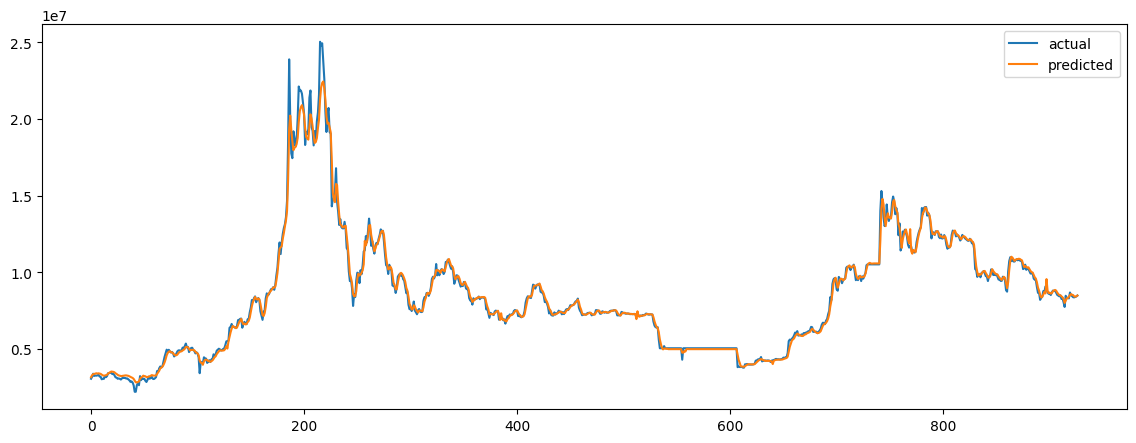

In [90]:
show_plot(model, train_loader, device)

100%|██████████| 2/2 [00:00<00:00,  7.06it/s]


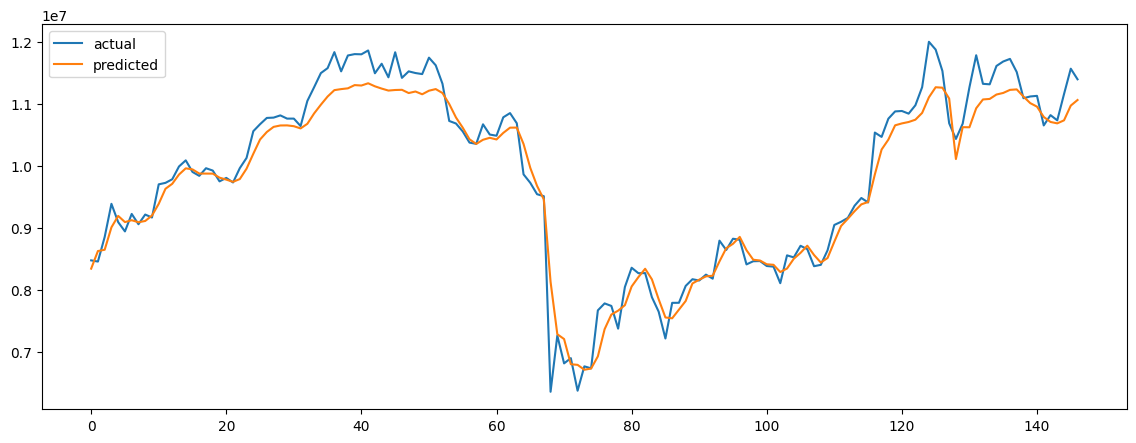

In [91]:
show_plot(model, val_loader, device)

100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


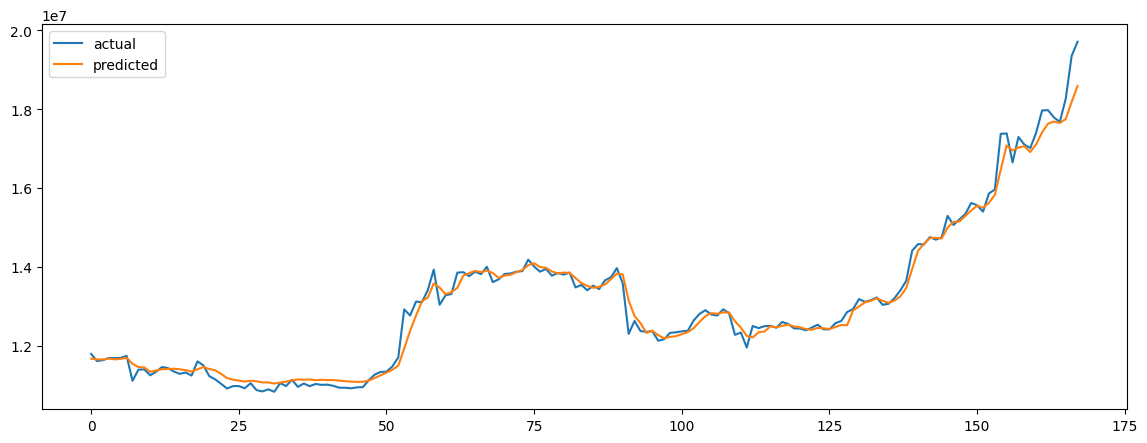

In [92]:
show_plot(model, test_loader, device)